```
Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         09/24/2017
Name:         Jeff Kao
Worked with:  Chuoran Wang, Mike Lin
```

# Week 1 Challenge: Benson

__Note: This challenge was done in pandas and without dictionaries.__

Before we start, import required libraries, show plots and turn off the chain assignment warning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Disable chain assignment warning
pd.options.mode.chained_assignment = None
# Plot inline
%matplotlib inline

## Challenge 1

Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. 

In [2]:
# Load our data into memory
# NB: we have already downloaded turnstile files locally, 
# so we only need to read them in using pandas

# download files start from...
startdate = datetime(2017, 9, 16)

# and ending at... (change enddate to read more/less files)
enddate = datetime(2017, 8, 1)
#enddate = datetime(2016, 9, 16)

# do..while
print('LOADING DATA...')
currdate = startdate
datestring = currdate.strftime('%y%m%d')
filename = 'turnstile_{}.txt'.format(datestring)
print(filename)
turnstile_df = pd.read_csv(filename)
while currdate > enddate:
    currdate = currdate - timedelta(days=7)
    datestring = currdate.strftime('%y%m%d')
    filename = 'turnstile_{}.txt'.format(datestring)
    print(filename)
    if turnstile_df is not None:
        turnstile_df = turnstile_df.append(pd.read_csv(filename))
    else:
        turnstile_df = pd.read_csv(filename)
print('DATA LOADED!')

LOADING DATA...
turnstile_170916.txt
turnstile_170909.txt
turnstile_170902.txt
turnstile_170826.txt
turnstile_170819.txt
turnstile_170812.txt
turnstile_170805.txt
turnstile_170729.txt
DATA LOADED!


**TA COMMENT:**

This is a clever way of reading your files from your local directory. However, it can be error-prone if the file names are not formatted the same way (ex: turnstile_170916.txt versus turnstiles_170916.txt). 

To mitigate this possible error, I would suggest using the os library, particularly the os.listdir() method within the os library. The os.listdir() will output an array containing all of the filenames within a particular directory.

In [3]:
# Strip/fix columns and index
df = turnstile_df.reset_index()
df.columns = [col.strip() for col in df.columns]

# Take a quick peek to make sure everything's fine
df.sample(5)

,index,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
553492,157352,157352,R245A,R051,01-00-02,59 ST,456NQRW,IRT,08/28/2017,08:00:00,REGULAR,5735723,8669035
1484309,94209,94209,N504,R021,02-06-01,42 ST-BRYANT PK,BDFM7,IND,07/28/2017,04:00:00,REGULAR,4994861,6622356
628320,32419,32419,H033,R313,00-00-02,BUSHWICK AV,L,BMT,08/22/2017,00:00:00,REGULAR,882753,1118470
1089111,96660,96660,N525,R142,01-00-01,DELANCEY/ESSEX,FJMZ,IND,08/06/2017,17:00:00,REGULAR,7798160,5012355
638322,42421,42421,N020,R101,00-00-03,145 ST,ABCD,IND,08/20/2017,08:00:00,REGULAR,9541321,11487027


In [4]:
# Useful functions:

# filter_series lets us pare down (mask) our initial data frame (useful for testing)
def filter_series(df, control_area=None, unit=None, device_address=None, station=None):
    return_series = df.copy()
    #filter can be string or list of strings
    if control_area:
        if isinstance(control_area, str):
            return_series = return_series.loc[df['C/A'] == control_area]
        elif isinstance(control_area, list):
            return_series = return_series.loc[df['C/A'].isin(control_area)]
        else:
            print('Warning: {} cannot be used as a filter because it is not a string or list'.format(control_area))
    if unit:
        if isinstance(unit, str):
            return_series = return_series.loc[df['UNIT'] == unit]
        elif isinstance(unit, list):
            return_series = return_series.loc[df['UNIT'].isin(unit)]
        else:
            print('Warning: {} cannot be used as a filter because it is not a string or list'.format(unit))
    if device_address:
        if isinstance(device_address, str):
            return_series = return_series.loc[df['SCP'] == device_address]
        elif isinstance(device_address, list):
            return_series = return_series.loc[df['SCP'].isin(device_address)]
        else:
            print('Warning: {} cannot be used as a filter because it is not a string or list'.format(device_address))
    if station:
        if isinstance(station, str):
            return_series = return_series.loc[df['STATION'] == station]
        elif isinstance(station, list):
            return_series = return_series.loc[df['STATION'].isin(station)]
        else:
            print('Warning: {} cannot be used as a filter because it is not a string or list'.format(station))
    return return_series

# get_time_series generates a cleaned-up time series for a single turnstile's dataframe
# useful for challenge 2
def get_time_series(df):
    t_time_series = df
    t_time_series['DATETIME_STR'] = t_time_series['DATE'] + ' ' + t_time_series['TIME']
    def str2datetime(datetime_str):
        return datetime.strptime(datetime_str, '%m/%d/%Y %H:%M:%S')
    def str2date(datetime_str):
        return datetime.strptime(datetime_str, '%m/%d/%Y')
    t_time_series['DATETIME'] = t_time_series['DATETIME_STR'].apply(str2datetime)
    t_time_series['DATE'] = t_time_series['DATE'].apply(str2date)
    t_time_series.sort_values('DATETIME', inplace=True)
    # now that we are sorted, we can subtract rows
    t_time_series['D_ENTRIES'] = t_time_series['ENTRIES'].diff()
    t_time_series['D_EXITS'] = t_time_series['EXITS'].diff()
    time_series = t_time_series.loc[:,['STATION','C/A','UNIT','SCP','DATE','DATETIME','ENTRIES','EXITS','D_ENTRIES','D_EXITS']]
    return time_series

**TA COMMENT:**

The filter_series function is awesome. Good job on accounting for edge cases.

The second function is good, but I'm not fully understanding why the t_time_series object is sorted by DATETIME _before_ being grouped by a particular station, C/A, UNIT, etc.. If you're sorting by DATETIME before the groupby operation then turnstiles with identical DATETIMEs will have their entries and exits counts subtracted. 

**After going through your challenge 2 code I get where you're going with this. However, as you probably noticed, the process of going through each turnstile individually is pretty slow. I would suggest changing the helper function to do the groupby operation _first_ before doing the entries and exits differences. That way you only do the subtraction operation _once_ rather than 4711 times.**

In [5]:
# OPTIONAL STEP:
# reduce dataset by filtering it
# df = df.filter_series(df, station=['14 ST-UNION SQ','TIMES SQ-42 ST','116 ST-COLUMBIA'])

# Sanity check on the (optionally reduced) dataset
df.shape

(1590212, 13)

In [6]:
turnstiles = df.groupby(['STATION','C/A','UNIT','SCP'])
print('There are {} unique turnstiles.'.format(len(turnstiles)))

# OPTIONALLY, print the keys for each turnstile (in case we need to access it later)
# for key, turnstile in turnstiles:
#     print(key)

There are 4711 unique turnstiles.


## Challenge 2

For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

__Note: get_time_series function is going to keep a few more columns in case we need to keep additional information.__

In [7]:
%%time

# iterate over the turnstiles and generate the time series for each
# this takes the longest
turnstile_timeseries_list = []
for key, turnstile in turnstiles:
    #print(key) #for debugging
    turnstile_timeseries_list.append(get_time_series(turnstile))
print('Aggregated data for {} turnstiles.'.format( len(turnstile_timeseries_list)))

Aggregated data for 4711 turnstiles.
CPU times: user 1min 8s, sys: 959 ms, total: 1min 9s
Wall time: 1min 11s


In [8]:
%%time

# reconsitute_full_df reconsitutes the full dataframe so that we can group by
def reconsitute_full_df(timeseries_list):
    full_df = pd.concat(timeseries_list, ignore_index=True)
    return full_df
all_turnstiles = reconsitute_full_df(turnstile_timeseries_list)

CPU times: user 1.47 s, sys: 156 ms, total: 1.63 s
Wall time: 1.81 s


Below are a couple of examples of data exploration and cleaning that could be done. Iterate until satisfied with results.

In [9]:
# Do some data exploration to make sure there's nothing off about it
# all_turnstiles[(all_turnstiles.STATION == '14 ST-UNION SQ') & (all_turnstiles.D_ENTRIES > 10)]
# wrong = all_turnstiles[(all_turnstiles['D_ENTRIES'] < 0) | (all_turnstiles['D_EXITS'] < 0)]
# wrong

In [10]:
# A bit of clean-up for the dataframe (there are likely other issues)
all_turnstiles = all_turnstiles.dropna(subset=['D_ENTRIES', 'D_EXITS'])
all_turnstiles['D_ENTRIES'] = all_turnstiles['D_ENTRIES'].apply(lambda x: abs(x))
all_turnstiles['D_EXITS'] = all_turnstiles['D_EXITS'].apply(lambda x: abs(x))
all_turnstiles['D_ENTRIES'] = all_turnstiles['D_ENTRIES'].apply(lambda x: 0 if x > 100000 else x)
all_turnstiles['D_EXITS'] = all_turnstiles['D_EXITS'].apply(lambda x: 0 if x > 100000 else x)

In [11]:
# After clean-up, may want to check issues with our aggregates against the original data
# Lather, rinse, repeat
# df3 = filter_series(df, station='14 ST-UNION SQ', control_area='A035', unit='R170', device_address='00-00-04')
# df3 = filter_series(df, station='TIMES SQ-42 ST', control_area='R148', unit='R033', device_address='01-00-01')
# df3.head()

In [12]:
# Challenge 2 done
all_turnstiles.head()

,STATION,C/A,UNIT,SCP,DATE,DATETIME,ENTRIES,EXITS,D_ENTRIES,D_EXITS
1,1 AV,H007,R248,00-00-00,2017-07-22,2017-07-22 04:00:00,12544595,13873669,82.0,335.0
2,1 AV,H007,R248,00-00-00,2017-07-22,2017-07-22 08:00:00,12544672,13874013,77.0,344.0
3,1 AV,H007,R248,00-00-00,2017-07-22,2017-07-22 16:00:00,12545802,13875753,1130.0,1740.0
4,1 AV,H007,R248,00-00-00,2017-07-22,2017-07-22 20:00:00,12546454,13876825,652.0,1072.0
5,1 AV,H007,R248,00-00-00,2017-07-23,2017-07-23 00:00:00,12546838,13877622,384.0,797.0


## Challenge 3

Prompt 1: These counts are for every n hours. (What is n?) (for most stations, n = 4)

Prompt 2: We want total daily entries. Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [13]:
daily_df = all_turnstiles.groupby(['STATION','C/A','UNIT','SCP','DATE'], as_index=False).sum()
daily_df.head()

,STATION,C/A,UNIT,SCP,DATE,ENTRIES,EXITS,D_ENTRIES,D_EXITS
0,1 AV,H007,R248,00-00-00,2017-07-22,50181523,55500260,1941.0,3491.0
1,1 AV,H007,R248,00-00-00,2017-07-23,75284252,83272042,1864.0,3547.0
2,1 AV,H007,R248,00-00-00,2017-07-24,75298590,83294381,3346.0,4109.0
3,1 AV,H007,R248,00-00-00,2017-07-25,75320194,83319801,3788.0,4389.0
4,1 AV,H007,R248,00-00-00,2017-07-26,75343108,83345849,3859.0,4253.0


## Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:
```
%matplotlib inline
```
This will make your matplotlib graphs integrate nicely with the notebook. To plot the time series, import matplotlib with
```
import matplotlib.pyplot as plt
```
Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:
```
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
```

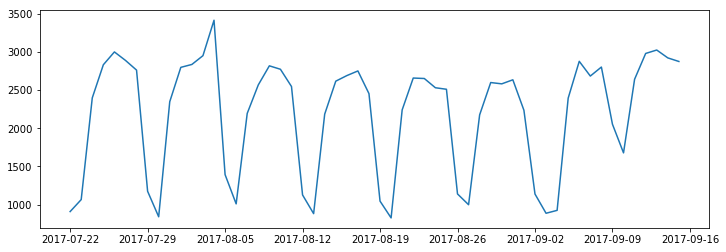

In [14]:
temp_df = filter_series(daily_df, station='TIMES SQ-42 ST', control_area='R148', unit='R033', device_address='01-00-01')
plt.figure(figsize=(12,4))
plt.plot(temp_df['DATE'].tolist(),temp_df['D_ENTRIES'].tolist());

## Challenge 5

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [15]:
# Group and drop columns no longer meaningful
daily_unit_df = all_turnstiles.groupby(['STATION','C/A','UNIT','DATE'], as_index=False).sum().drop(['ENTRIES','EXITS'], axis=1)
daily_unit_df.sample(5)

,STATION,C/A,UNIT,DATE,D_ENTRIES,D_EXITS
22490,CLASSON AV,N419,R287,2017-08-26,2593.0,2714.0
22419,CLARK ST,R600,R224,2017-08-11,5814.0,3349.0
30123,JKSN HT-ROOSVLT,N323,R018,2017-07-25,11351.0,9362.0
31386,LAFAYETTE AV,N110,R283,2017-08-25,4276.0,1950.0
4820,18 AV,D008,R392,2017-07-26,4393.0,4684.0


## Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [16]:
# Group and drop columns no longer meaningful
daily_station_df = (all_turnstiles.groupby(['STATION','DATE'], as_index=False)
                    .sum()
                    .drop(['ENTRIES','EXITS'], axis=1))
daily_station_df.sample(5)

,STATION,DATE,D_ENTRIES,D_EXITS
17863,PRESIDENT ST,2017-07-25,3809.0,4048.0
7004,ATL AV-BARCLAY,2017-09-11,43024.0,40831.0
2133,2 AV,2017-07-27,17037.0,17131.0
17250,OZONE PK LEFFRT,2017-07-28,7726.0,6795.0
11660,ELDER AV,2017-07-27,6484.0,6152.0


## Challenge 7
Plot time series for a station.

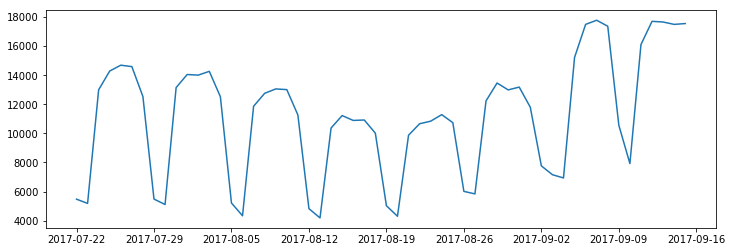

In [17]:
plot_df = (filter_series(all_turnstiles, station=['116 ST-COLUMBIA'])
           .groupby(['STATION','DATE'], as_index=False)
           .sum()
           .drop(['ENTRIES','EXITS'], axis=1))
plt.figure(figsize=(12,4))
plt.plot(plot_df['DATE'].tolist(),plot_df['D_ENTRIES'].tolist());

## Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [18]:
plot_df['DAY_OF_WEEK'] = plot_df['DATE'].apply(lambda x: datetime.weekday(x))

In [19]:
plot_df['WEEK_OF_YEAR'] = plot_df['DATE'].apply(lambda x: x.isocalendar()[1])

In [20]:
rainbow_groups = plot_df.groupby('WEEK_OF_YEAR', as_index=True)

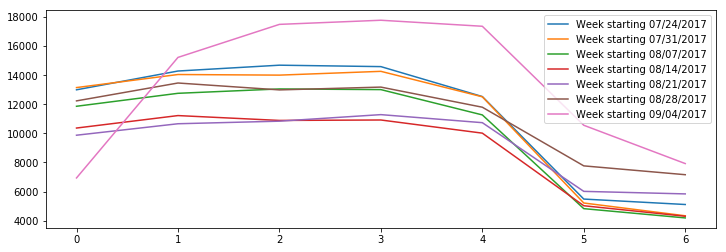

In [21]:
handle_list = []
plt.figure(figsize=(12,4))
for week, rainbow_group in rainbow_groups:
    #only plot full weeks
    if rainbow_group.shape[0] == 7:
        datestr = datetime.strftime(rainbow_group['DATE'].iloc[0],'%m/%d/%Y')
        handle, = plt.plot(rainbow_group['DAY_OF_WEEK'].tolist(), 
                  rainbow_group['D_ENTRIES'].tolist(), 
                  label='Week starting ' + datestr
                          );
        handle_list.append(handle)
plt.legend(handles=handle_list);

**TA COMMENT:**

Good job on the plotting. Really clean way of plotting a multiseries line plot.

## Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [22]:
station_df = (all_turnstiles
           .groupby(['STATION'], as_index=False)
           .sum()
           .drop(['ENTRIES','EXITS'], axis=1))
station_df.sort_values('D_ENTRIES', ascending=False).head()

,STATION,D_ENTRIES,D_EXITS
61,34 ST-PENN STA,7373058.0,6380639.0
232,GRD CNTRL-42 ST,6869565.0,6442006.0
59,34 ST-HERALD SQ,5945489.0,5322942.0
46,23 ST,5291854.0,3919629.0
14,14 ST-UNION SQ,5099716.0,4367453.0


## Challenge 10

Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

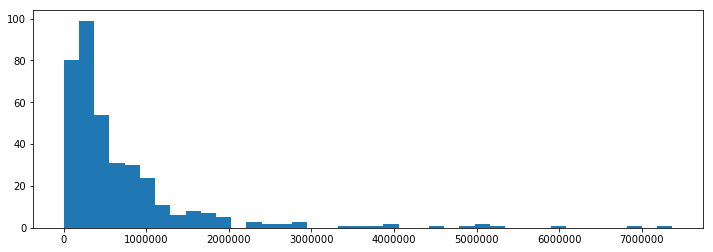

In [23]:
plt.figure(figsize=(12,4))
plt.hist(station_df['D_ENTRIES'].tolist(), bins=40);

**TA COMMENT:**

Great job! Your coding is really advanced and your handle on pandas is great as well. I left comments throughout the notebook so take a look at those, but other than that I don't really have any suggestions on improving your code.